In [4]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
# from yahoo_finance import Share
from pandas_datareader import data, wb

from sklearn import metrics
from sklearn.cluster import KMeans
# from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import math
import scipy.stats as s

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [5]:
def sub_data(filename_data, filename_symbology, dir_pickle, start_date, end_date, query_attribute, query_criteria,
             include_avg):
    query_criteria_filename = '-'.join(query_criteria[:3])
    pickle_name = dir_pickle +'pickle_sentiment_'+ start_date +'_'+ end_date +'_'+ query_attribute + '_' + query_criteria_filename +'.p'
    try: 
        data = pd.read_pickle(pickle_name)
        print("Loaded from pre-created pickle")
    except:
        print("Subsampling data from csv")
        # try to read first from pickle
        # read csv
        data = pd.read_csv(filename_data)
        # merge with symbology csv for additional info
        data_symbology = pd.read_csv(filename_symbology)
        # convert headers to uppercase for ease of use
        data_symbology.columns = [x.upper() for x in data_symbology.columns]
        data = pd.merge(data, data_symbology, left_on='SYMBOL', right_on='SYMBOL', how = "left")
        # perform filter query based on parameters
        data = data[data[query_attribute].isin(query_criteria)]
        # convert timestamps to datetime objects
        data['DATE'] = data['TIMESTAMP_UTC'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
            # datetime.strftime('%x')   only keep date but type is string   09/12/10
        data['DATE'] = data['DATE'].apply(lambda x: x.strftime('%x'))
            # pd.to_datetime()   change string to datetime type   2010-10-20
        data['DATE'] = data['DATE'].apply(lambda x: pd.to_datetime(x))
        # query between start and end date
        data = data[(data['DATE'] > start_date) & (data['DATE'] < end_date)]
        
        # remove columns which contain 'avg' in column name
        if include_avg == False:
            avg_cols = [col for col in data.columns if 'AVG' in col]
            data.drop(avg_cols,inplace=True,axis=1)
        # save as pickle
        data.to_pickle(pickle_name)
    # return dataframe
    return data

In [6]:
# function to return historical finance data
# takes a list of ticker symbols
# if sum_data_frame is true -> create a summed value to form an indic (combine data frame together for diff companies)
# else create a concatenated dataframe
def get_data_finance(source, symbols, start_date, end_date, dir_pickle, sum_data_frame, sum_symbol):
    symbols_filename = '-'.join(symbols[:3])
    pickle_name = dir_pickle+'pickle_finance_'+str(sum_data_frame)+start_date+'_'+end_date+'_'+symbols_filename+'.p'
    try: 
        data_finance = pd.read_pickle(pickle_name)
        print("Loaded from pre-created pickle")
    except:
        print("Scraping and saving data from Yahoo")
        # get finance data using pandas data reader
        print("0: " + symbols[0])
        # create df from first symbol
        try:
            data_finance = data.DataReader(symbols[0], source, start_date, end_date)
            # convert headers to uppercase for ease of use
            data_finance.columns = [x.upper() for x in data_finance.columns]
            if sum_data_frame:
                data_finance['SYMBOL'] = sum_symbol
            else:
                data_finance['SYMBOL'] = symbols[0]
        except: 
            print("Unable to retrieve data for: " + symbols[0])
            
        # loop through remaining symbols and either add or concatenate
        i = 1
        for symbol in symbols[1:]:
            print(str(i) + ": " + symbol)
            i += 1
            try:
                symbol_finance = data.DataReader(symbol, source, start_date, end_date)
                # convert headers to uppercase for ease of use
                symbol_finance.columns = [x.upper() for x in symbol_finance.columns]
                # sum dataframes
                if sum_data_frame:
                    symbol_finance['SYMBOL'] = sum_symbol
                    data_finance = data_finance + symbol_finance
                    data_finance['SYMBOL'] = sum_symbol
                # vertically concat dataframes
                else:
                    symbol_finance['SYMBOL'] = symbol
                    data_finance = pd.concat([data_finance, symbol_finance], axis=0)
            except: 
                print("Unable to retrieve data for: " + symbol)
        # reset index (optional)
        data_finance.reset_index(level=0, inplace=True)
        # convert headers to uppercase for ease of use
        data_finance.columns = [x.upper() for x in data_finance.columns]
            # Sort by date
#         data_finance = data_finance.sort_values(['DATE'], ascending=[True])
        data_finance.to_pickle(pickle_name)
    # return as dataframe
    return data_finance  

In [7]:
#preprocess sentiment data with additional columns for:
def preprocess_data_sentiment(df):
    # log bull messages
    df['LOG_BULL_RETURN'] = np.log(1+df['BULL_SCORED_MESSAGES']).diff()
    # log bear messages
    df['LOG_BEAR_RETURN'] = np.log(1+df['BEAR_SCORED_MESSAGES']).diff()
    # log bullishness
    df['LOG_BULLISHNESS'] = np.log(1 + df['BULL_SCORED_MESSAGES']) - np.log(1 + df['BEAR_SCORED_MESSAGES'])
    # log bull bear ratio
    df['LOG_BULL_BEAR_RATIO'] = np.log(df['BULL_SCORED_MESSAGES']) - np.log(df['BEAR_SCORED_MESSAGES'])
    # TISf
    df['TISf'] = (1+df['BULL_SCORED_MESSAGES'])/(1+ df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES'])
    # RTISf
    df['RTISf'] = ((1+df['BULL_SCORED_MESSAGES'])/(1+ df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES'])).pct_change()
    # diff in total scanned messages
    df['TOTAL_SCANNED_MESSAGES_DIFF'] = df['TOTAL_SCANNED_MESSAGES'].diff()
    # diff in total sentiment messages
    df['TOTAL_SENTIMENT_MESSAGES_DIFF'] = np.log(1+df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES']).diff()
def preprocess_data_finance(df):
    # log return based on Adj close price
    df['LOG_RETURN'] = np.log(df['ADJ CLOSE']) - np.log(df['ADJ CLOSE'].shift(1))
    # volatitility
    df['VOLATILITY'] = df['HIGH'] - df['LOW']
    # difference in volume
    df['LOG_VOLUME_DIFF'] = np.log(df['VOLUME']).diff()

In [8]:
def merge_sentiment_finance(data_sentiment, data_finance, with_symbol, to_sentiment, to_finance):
    if with_symbol:
        if to_finance:
            return pd.merge(data_sentiment, data_finance, on=['DATE', 'SYMBOL'], how='right')
        if to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE', 'SYMBOL'], how='left')
    else:
        if to_finance:
            return pd.merge(data_sentiment, data_finance, on=['DATE'], how='right')
        if to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE'], how='left')

In [9]:
# check autocorrelation
def check_acf(df):
    df_num = df.select_dtypes(include=[np.float, np.int])
    for index in df_num.columns:
        plt.figure(figsize=(8,10))
        if index in ['LOG_BULL_RETURN', 'LOG_BEAR_RETURN','RTISf', 'TOTAL_SCANNED_MESSAGES_DIFF', 'TOTAL_SENTIMENT_MESSAGES_DIFF']:
            fig = sm.graphics.tsa.plot_acf(df_num[index][1:],lags=40)
            plt.title(index)
        elif index in ['LOG_BULL_BEAR_RATIO']:
            fig = sm.graphics.tsa.plot_acf(df_num[index][2:],lags=40)
            plt.title(index)
        else: 
            fig = sm.graphics.tsa.plot_acf(df_num[index],lags=40)
            plt.title(index)
    return fig

# Bin selection

In [10]:
# Sturges’ formula: k = log_2 n + 1  
def sturges_bin(df):
    n = df.count()[1]
    return math.ceil(np.log2(n)+1)
# Rice Rule k = 2 n^{1/3}
def rice_bin(df):
    n = df.count()[1]
    return math.ceil(2*n**(1/3)) 
# Doane’s formula for non-normal data.
def doane_bin(data):
    n = data.count()
    std = np.std(data)
    g = abs(s.moment(n,3)/(std**3))
    u = math.sqrt(6*(n-1)/((n+1)*(n+3)))
    return round(1 + np.log2(n) + np.log2(1+g/u))

In [11]:
def apply_rolling_window(df, width):
    df = df.ix[1:, :]
    df_num = df.select_dtypes(include=[np.float, np.int])
    df_non_num = df.select_dtypes(exclude=[np.float, np.int])
    df_num_window = pd.rolling_mean(df_num, width, min_periods=1)
    df_window = pd.concat([df_non_num, df_num_window], axis=1)
    return df_window

def correlation_analysis(df):
    i = 0
    resCorr = pd.DataFrame(index = ['BULLISH_INTENSITY','BEARISH_INTENSITY','BULL_MINUS_BEAR','BULL_SCORED_MESSAGES',
                                    'BEAR_SCORED_MESSAGES', 'LOG_BULL_RETURN', 'LOG_BULL_RETURN','LOG_BULLISHNESS',
                                    'TOTAL_SENTIMENT_MESSAGES_DIFF','TISf','RTISf'],
                           columns = ['LOG_RETURN','VOLUME','VOLATILITY'])
    for column in resCorr.index:
        resCorr.ix[i,0] = df['LOG_RETURN'].corr(df[column])
        resCorr.ix[i,1] = df['VOLUME'].corr(df[column])
        resCorr.ix[i,2] = df['VOLATILITY'].corr(df[column])
        i += 1
    return resCorr

def calc_mutual_information(varsenti, varfinan):
    bins = doane_bin(varsenti)
    c_xy = np.histogram2d(varsenti, varfinan, bins)[0]
    mi = metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi

# shift vary (finance data); keep varx (sentiment data).
def information_surplus(df, time_shift, varsenti, varfinan):   
    output = []
    for i in range(0, time_shift+1):
        x = df[varsenti].ix[1+i:]
        shift_y = df[varfinan].shift(i)
        y = shift_y.ix[1+i:]
        mi = calc_mutual_information(x, y)
        if i == 0:
            mi_origin = mi
        output.append({'SHIFT': i, 'MUTUAL INFORMATION': mi, 'INFORMATION_SURPLUS_DIFF': mi - mi_origin, 
                       'INFORMATION_SURPLUS_PCT': (mi - mi_origin) / mi_origin * 100})
    output_frame = pd.DataFrame(output)
    return output_frame

In [12]:
# print(sturges_bin(df_s))
# print(rice_bin(df_s))
print(doane_bin(df_s['BULL_MINUS_BEAR']))

NameError: name 'df_s' is not defined

# Application

In [13]:
# notebook-wide experiemental configuration
data_primary = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology = '../../data/csv/symbology.csv'
data_pickles = '../../data/pickles/'
start_date = '2010-01-01'
end_date = '2016-01-01'

In [14]:
data_s = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['AAPL'], False)
data_f = get_data_finance('yahoo', ['AAPL'], start_date, end_date, '../../data/pickles/', False, 'NAN')

Loaded from pre-created pickle
Loaded from pre-created pickle


# autocorrelation test

In [15]:
# use roll window before data process and store in data
# data = apply_rolling_window(data_s, 2)
# preprocess_data_sentiment(data)
preprocess_data_sentiment(data_s)
preprocess_data_finance(data_f)
# df_num = data_s.select_dtypes(include=[np.float, np.int])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


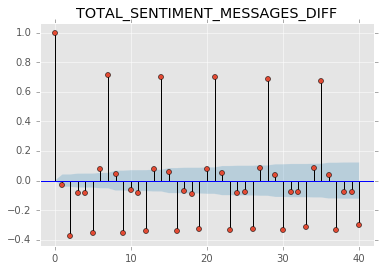

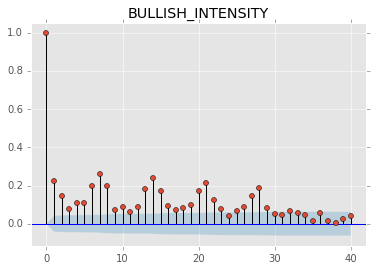

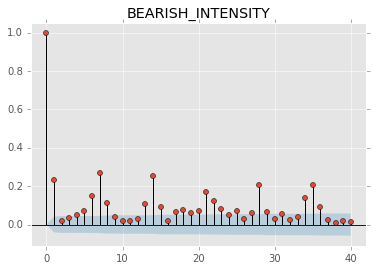

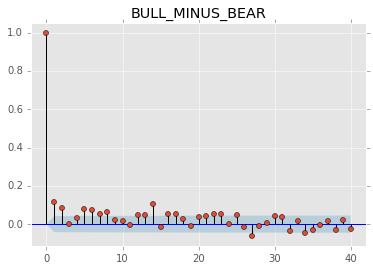

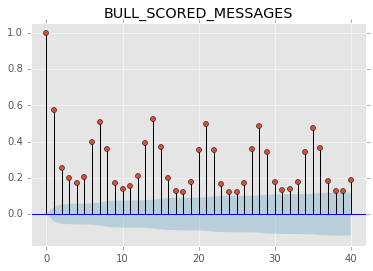

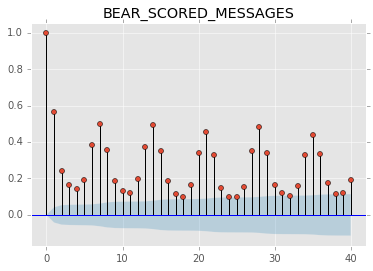

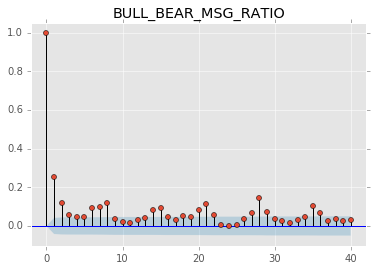

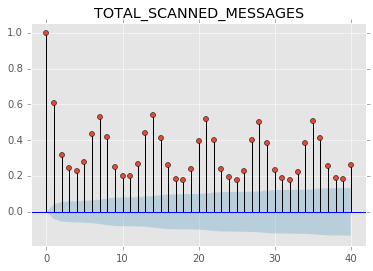

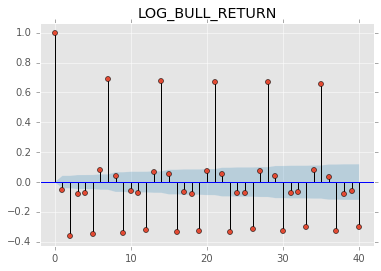

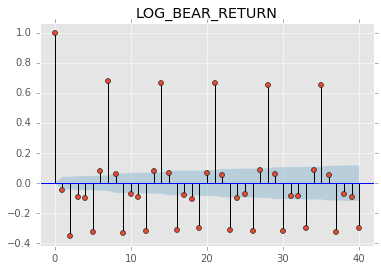

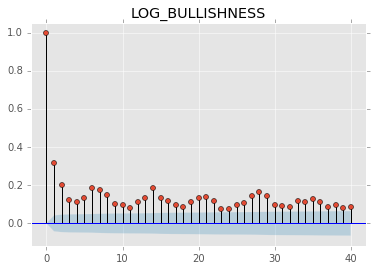

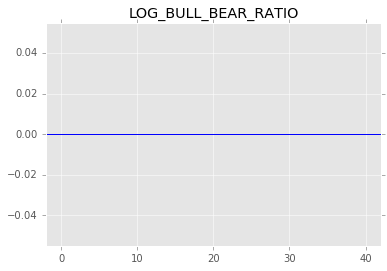

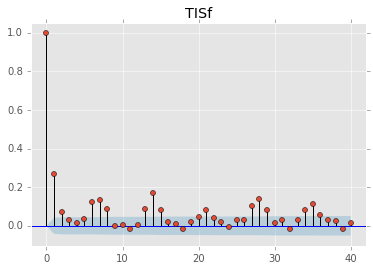

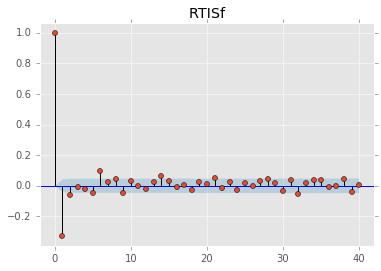

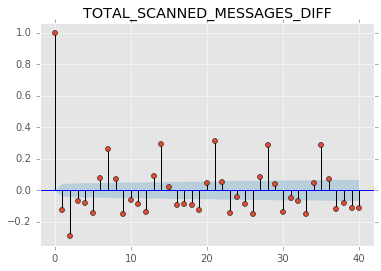

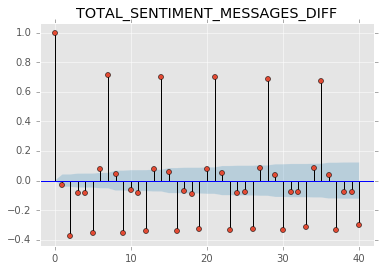

In [16]:
check_acf(data_s)

In [17]:
data_m = apply_rolling_window(data_s, 1)


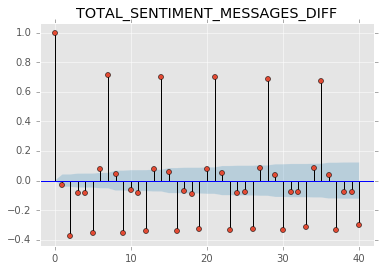

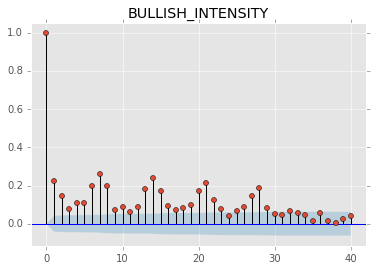

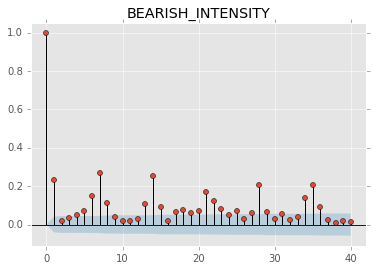

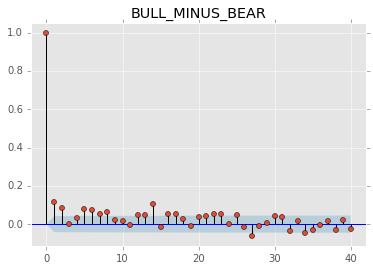

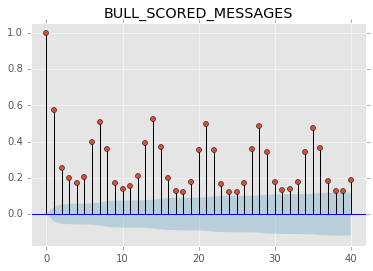

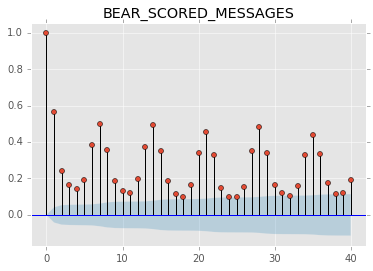

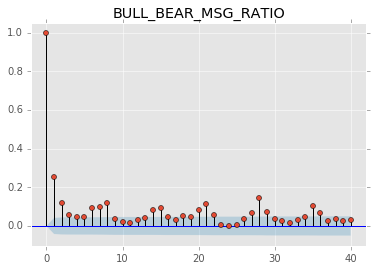

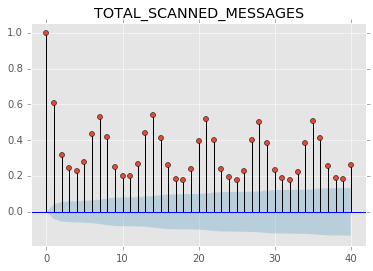

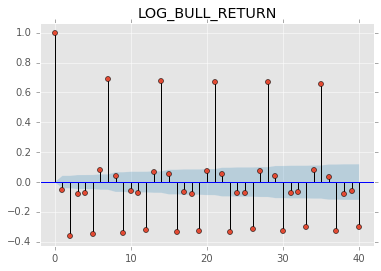

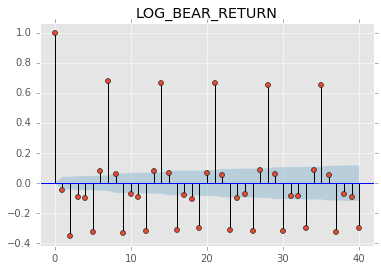

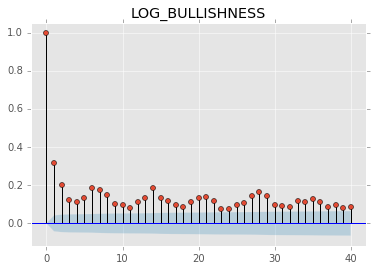

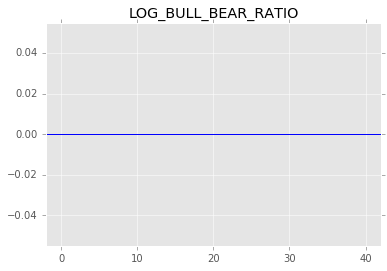

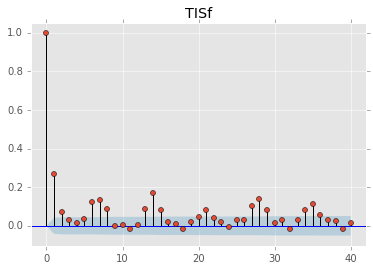

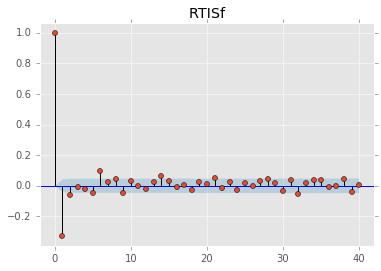

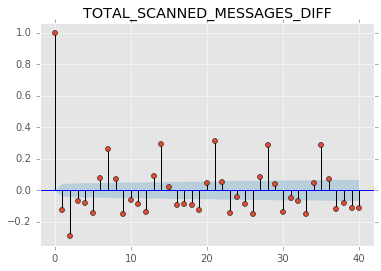

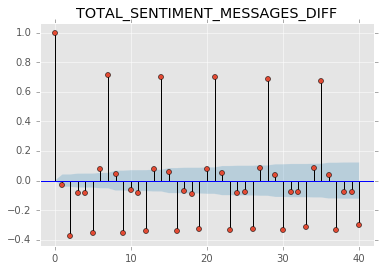

In [18]:
check_acf(data_m)

# Merge dataset and Correlation

In [19]:
merged = merge_sentiment_finance(data_m, data_f, True, False, True)
correlation_analysis(merged)

,LOG_RETURN,VOLUME,VOLATILITY
BULLISH_INTENSITY,0.239548,-0.146964,-0.136736
BEARISH_INTENSITY,-0.176443,0.0837009,0.0734985
BULL_MINUS_BEAR,0.275676,-0.151897,-0.138166
BULL_SCORED_MESSAGES,-0.0362217,0.0632091,0.269172
BEAR_SCORED_MESSAGES,-0.230058,0.160138,0.34918
LOG_BULL_RETURN,0.123358,0.0781549,0.138411
LOG_BULL_RETURN,0.123358,0.0781549,0.138411
LOG_BULLISHNESS,0.372395,-0.243092,-0.176692
TOTAL_SENTIMENT_MESSAGES_DIFF,0.0759167,0.0789003,0.141627
TISf,0.382894,-0.214057,-0.205698


In [20]:
merged.columns

Index([u'SOURCE', u'SYMBOL', u'TIMESTAMP_UTC', u'EXCHANGE', u'SECTOR',
       u'INDUSTRY', u'TITLE', u'DATE', u'BULLISH_INTENSITY',
       u'BEARISH_INTENSITY', u'BULL_MINUS_BEAR', u'BULL_SCORED_MESSAGES',
       u'BEAR_SCORED_MESSAGES', u'BULL_BEAR_MSG_RATIO',
       u'TOTAL_SCANNED_MESSAGES', u'LOG_BULL_RETURN', u'LOG_BEAR_RETURN',
       u'LOG_BULLISHNESS', u'LOG_BULL_BEAR_RATIO', u'TISf', u'RTISf',
       u'TOTAL_SCANNED_MESSAGES_DIFF', u'TOTAL_SENTIMENT_MESSAGES_DIFF',
       u'OPEN', u'HIGH', u'LOW', u'CLOSE', u'VOLUME', u'ADJ CLOSE',
       u'LOG_RETURN', u'VOLATILITY', u'LOG_VOLUME_DIFF'],
      dtype='object')

# Information surplus

In [21]:
def information_surplus_df(df, time_shift, varfinan):
    result_df = pd.DataFrame(index = range(11),
                           columns = ['BULLISH_INTENSITY','BEARISH_INTENSITY','BULL_MINUS_BEAR','LOG_BULLISHNESS',
                                    'TOTAL_SENTIMENT_MESSAGES_DIFF','TISf'])
    for column in res.columns:
        information_theory_df = information_surplus(df, time_shift, df[column], varfinan)
        res[column] = information_theory_df
        i += 1
    return resCorr

In [22]:
information_surplus(merged, 10,'BULLISH_INTENSITY','LOG_RETURN')

ValueError: cannot convert float NaN to integer

In [22]:
information_surplus(merged, 5,'BEARISH_INTENSITY','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.032810,0
1,0.001190,3.627202,0.034000,1
2,-0.004397,-13.401844,0.028413,2
3,-0.006218,-18.950439,0.026593,3
4,-0.000179,-0.546834,0.032631,4
5,-0.002023,-6.165038,0.030788,5


In [21]:
information_surplus(merged, 10,'BULL_MINUS_BEAR','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.038514,0
1,0.008534,22.157241,0.047048,1
2,0.007355,19.097539,0.045869,2
3,0.010185,26.444829,0.048699,3
4,0.017186,44.622216,0.055700,4
5,0.003570,9.268857,0.042084,5
6,0.004267,11.077933,0.042781,6
7,0.001613,4.187363,0.040127,7
8,-0.007349,-19.081793,0.031165,8
9,0.000920,2.388030,0.039434,9


In [23]:
information_surplus(merged, 3,'LOG_BULL_RETURN','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.059519,0
1,-0.022648,-38.051527,0.036871,1
2,-0.028108,-47.224978,0.031411,2
3,-0.030500,-51.244356,0.029019,3


In [24]:
information_surplus(merged, 3,'LOG_BEAR_RETURN','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.067040,0
1,-0.025749,-38.407969,0.041291,1
2,-0.042197,-62.943634,0.024843,2
3,-0.040889,-60.991674,0.026151,3


In [25]:
information_surplus(merged, 10,'LOG_BULLISHNESS','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.038411,0
1,0.012396,32.272346,0.050807,1
2,0.013146,34.225147,0.051557,2
3,0.017693,46.062784,0.056104,3
4,0.011289,29.389747,0.049700,4
5,-0.003214,-8.367761,0.035197,5
6,-0.008468,-22.045193,0.029943,6
7,-0.010428,-27.147478,0.027983,7
8,-0.009661,-25.150463,0.028751,8
9,-0.007536,-19.620304,0.030875,9


In [26]:
information_surplus(merged, 10,'TISf','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.039890,0
1,0.016308,40.882027,0.056198,1
2,0.017704,44.380899,0.057594,2
3,0.027327,68.504685,0.067217,3
4,0.018008,45.143000,0.057898,4
5,0.001702,4.267602,0.041593,5
6,-0.010749,-26.946986,0.029141,6
7,-0.009165,-22.976549,0.030725,7
8,-0.011011,-27.603258,0.028879,8
9,-0.010228,-25.641162,0.029662,9


In [27]:
information_surplus(merged, 3,'TOTAL_SCANNED_MESSAGES_DIFF','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.055988,0
1,-0.020993,-37.495572,0.034995,1
2,-0.032124,-57.377118,0.023864,2
3,-0.033440,-59.727917,0.022548,3


In [28]:
information_surplus(merged, 3,'TOTAL_SENTIMENT_MESSAGES_DIFF','LOG_RETURN')

,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT,MUTUAL INFORMATION,SHIFT
0,0.000000,0.000000,0.069669,0
1,-0.034009,-48.815142,0.035660,1
2,-0.044117,-63.324386,0.025552,2
3,-0.043757,-62.807478,0.025912,3


In [533]:
# bins = rice_bin(df_s)
# bins = sturges_bin(df_s)
# bins = doane_bin(df_s['LOG_BULLISHNESS'])
# print(bins) 

# K-means

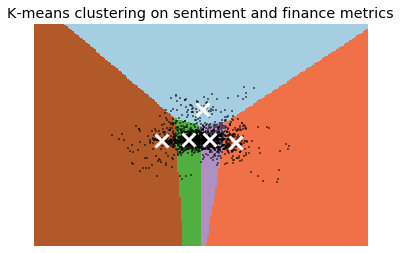

In [17]:
df = merged
df_n = df.select_dtypes(include=[np.float, np.int])
# print (df_n.info())
df_num = df_n.ix[1:,['BULL_MINUS_BEAR', 'LOG_BULLISHNESS', 'LOG_RETURN']]
# Convert DataFrame to matrix
mat = df_num.as_matrix()
km = KMeans()
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
data = mat
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)
h = .02 
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on sentiment and finance metrics')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()